In [248]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import seaborn as sns
from collections import Counter
%matplotlib inline

### Set up data

In [151]:
data=pd.read_csv("data/COADREAD.protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.data.txt",sep="\t",index_col=0,skiprows=[1])
data.columns=[str.lower(x)[:12] for x in data.columns]
data=data.fillna(0)
data.head()

,tcga-3l-aa1b,tcga-4n-a93t,tcga-4t-aa8h,tcga-5m-aat5,tcga-5m-aat6,tcga-5m-aata,tcga-a6-2671,tcga-a6-2672,tcga-a6-2676,tcga-a6-2677,...,tcga-f5-6811,tcga-f5-6812,tcga-f5-6813,tcga-f5-6861,tcga-f5-6863,tcga-f5-6864,tcga-g5-6233,tcga-g5-6235,tcga-g5-6572,tcga-g5-6641
Sample REF,,,,,,,,,,,,,,,,,,,,,
14-3-3_beta,-0.080528,-0.157540,-0.384060,-0.087426,-0.275405,-0.224685,-0.079293,-0.336623,-0.187790,-0.235185,...,-0.024839,0.632183,-0.237272,-0.023691,0.410173,0.157596,0.487429,0.052631,0.137889,0.044996
14-3-3_epsilon,0.055408,0.059789,0.162856,-0.152768,-0.041336,-0.075951,-0.028777,-0.475157,-0.111809,-0.494886,...,0.049617,0.176068,-0.001045,-0.034187,0.153054,0.034974,0.351664,0.149957,0.103203,0.042900
14-3-3_zeta,-0.002074,-0.133746,0.268501,-0.099586,0.274313,0.211939,0.143781,0.167963,0.207375,1.052479,...,-0.289523,-0.481528,-0.220994,-0.163810,-0.383245,-0.317986,-0.168820,0.049888,0.026328,-0.492910
4E-BP1,-0.026155,-0.358218,0.326340,-0.155025,-0.155358,0.225123,-0.397172,0.253190,0.011756,-0.011091,...,-0.152306,-0.304178,0.184011,-0.100291,-0.949681,-0.035973,0.211097,0.038849,-0.109916,-0.168386
4E-BP1_pS65,-0.110226,-0.152775,-0.138170,-0.093734,0.118912,-0.315533,0.804923,0.011820,-0.306448,0.427429,...,-0.201527,0.530600,-0.312147,0.257025,2.374363,-0.000493,0.045489,0.117049,-0.378221,-0.315304


In [152]:
clinical_data_df = pd.read_table('data/clinical/COADREAD.clin.merged.txt', index_col=0,skiprows=16) #import staging
patientsToKeep=[x for x in clinical_data_df.columns if "stage" in str(clinical_data_df.loc["patient.stage_event.pathologic_stage",x])] # keep patients with data
patientsToKeep=[x for x in patientsToKeep if x in data.columns] #keep patients with mRNA data
clinical_data_df=clinical_data_df[patientsToKeep] #subset to what we want
patClassification={x:clinical_data_df.loc["patient.stage_event.pathologic_stage",x] for x in clinical_data_df.columns} #create lookup table
patCellType={x:clinical_data_df.loc["patient.tumor_tissue_site",x] for x in clinical_data_df.columns} #create lookup table
data=data[patientsToKeep] #subset to what we want
convertStageToNum={
'stage i':1,
 'stage ia':1.5,
 'stage ii':2,
 'stage iia':2.25,
 'stage iib':2.5,
 'stage iic':2.75,
 'stage iii':3,
 'stage iiia':3.25,
 'stage iiib':3.5,
 'stage iiic':3.75,
 'stage iv':4,
 'stage iva':4.33,
 'stage ivb':4.66    
}

### We now need to make 4 sets of data:  training and test for each of the two cell types

In [163]:
colonData=data[[x for x in data.columns if patCellType[x]=="colon"]]
rectumData=data[[x for x in data.columns if patCellType[x]=="rectum"]]

### Right now lets not do bootstrapping and just do a split based on ratios

So lets use 6:10 rectum to colon patients

Lets also train at a 5:1 rate, so we will train 299 and test 60 for colon and use the proper ratio of rectum

In [164]:
print("Number of total  patients:"+str(len(data.columns)))
print("Number of colon  patients:"+str(len(colonData.columns)))
print("Number of rectum patients:"+str(len(rectumData.columns)))
print("Ratio:"+str(len(rectumData.columns)/len(colonData)))

Number of total  patients:478
Number of colon  patients:359
Number of rectum patients:123
Ratio:0.5913461538461539


In [166]:
colonTrain=colonData.iloc[:,[i for i in range(299)]]
colonTest=colonData.iloc[:,[i for i in range(299,len(colonData.columns))]]
rectumTrain=rectumData.iloc[:,[i for i in range(int(5/6*len(rectumData.columns)))]]
rectumTest=rectumData.iloc[:,[i for i in range(int(5/6*len(rectumData.columns)),len(rectumData.columns))]]
totalTrain=data.iloc[:,[i for i in range(int(5/6*len(data.columns)))]]
totalTest=data.iloc[:,[i for i in range(int(5/6*len(data.columns)),len(data.columns))]]

In [167]:
colonTrainingLabels=[patClassification[str.lower(x)] for x in colonTrain.columns]
colonTrainingLabels=[convertStageToNum[x] for x in colonTrainingLabels]
colonTestingLabels=[patClassification[str.lower(x)] for x in colonTest.columns]
colonTestingLabels=[convertStageToNum[x] for x in colonTestingLabels]
rectumTrainingLabels=[patClassification[str.lower(x)] for x in rectumTrain.columns]
rectumTrainingLabels=[convertStageToNum[x] for x in rectumTrainingLabels]
rectumTestingLabels=[patClassification[str.lower(x)] for x in rectumTest.columns]
rectumTestingLabels=[convertStageToNum[x] for x in rectumTestingLabels]
totalTrainingLabels=[patClassification[str.lower(x)] for x in totalTrain.columns]
totalTrainingLabels=[convertStageToNum[x] for x in totalTrainingLabels]
totalTestingLabels=[patClassification[str.lower(x)] for x in totalTest.columns]
totalTestingLabels=[convertStageToNum[x] for x in totalTestingLabels]

### Try linear regression

In [157]:
from sklearn import linear_model

In [208]:
EN=linear_model.ElasticNetCV(max_iter=10000,fit_intercept=False)

##### Colon

In [229]:
EN=EN.fit(colonTrain.transpose(),colonTrainingLabels)

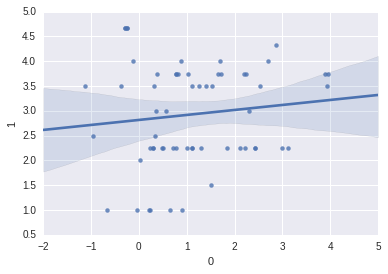

In [230]:
fitTemp=EN.predict(colonTest.transpose())
t=pd.DataFrame([(fitTemp[x],colonTestingLabels[x]) for x in range(len(fitTemp))])
sns.regplot(x=t[0],y=t[1])

##### Rectum

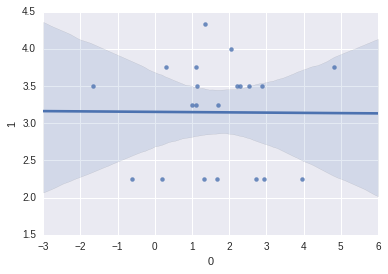

In [232]:
EN=EN.fit(rectumTrain.transpose(),rectumTrainingLabels)
fitTemp=EN.predict(rectumTest.transpose())
t=pd.DataFrame([(fitTemp[x],rectumTestingLabels[x]) for x in range(len(fitTemp))])
sns.regplot(x=t[0],y=t[1])

##### Combined

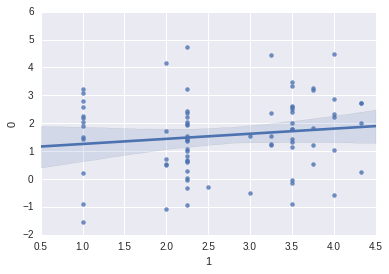

In [234]:
EN=EN.fit(totalTrain.transpose(),totalTrainingLabels)
fitTemp=EN.predict(totalTest.transpose())
t=pd.DataFrame([(fitTemp[x],totalTestingLabels[x]) for x in range(len(fitTemp))])
sns.regplot(x=t[1],y=t[0])

### Try logistic regression

##### Colon

In [268]:
LR=linear_model.LogisticRegression()
binaryColonLabels=[0 if x <=1 else 1 for x in colonTrainingLabels]
binaryColonTestLabels=[0 if x <=1 else 1 for x in colonTestingLabels]
LR.fit(X=colonTrain.transpose(),y=binaryColonLabels)
fitTemp=LR.predict(colonTest.transpose())
t=pd.DataFrame([(fitTemp[x],binaryColonTestLabels[x]) for x in range(len(fitTemp))])
TrueFalse=[1 if t.loc[x,0]==t.loc[x,1] else 0 for x in range(len(t))]
Counter(TrueFalse)

Counter({0: 10, 1: 50})

##### Rectum

In [269]:
LR=linear_model.LogisticRegression()
binaryRectumLabels=[0 if x <=1 else 1 for x in rectumTrainingLabels]
binaryRectumTestLabels=[0 if x <=1 else 1 for x in rectumTestingLabels]
LR.fit(X=rectumTrain.transpose(),y=binaryRectumLabels)
fitTemp=LR.predict(rectumTest.transpose())
t=pd.DataFrame([(fitTemp[x],binaryRectumTestLabels[x]) for x in range(len(fitTemp))])
TrueFalse=[1 if t.loc[x,0]==t.loc[x,1] else 0 for x in range(len(t))]
Counter(TrueFalse)

Counter({0: 3, 1: 18})

##### Total

In [274]:
LR=linear_model.LogisticRegression()
binaryTotalLabels=[0 if x <=1 else 1 for x in totalTrainingLabels]
binaryTotalTestLabels=[0 if x <=1 else 1 for x in totalTestingLabels]
LR.fit(X=totalTrain.transpose(),y=binaryTotalLabels)
fitTemp=LR.predict(totalTest.transpose())
t=pd.DataFrame([(fitTemp[x],binaryTotalTestLabels[x]) for x in range(len(fitTemp))])
TrueFalse=[1 if t.loc[x,0]==t.loc[x,1] else 0 for x in range(len(t))]
Counter(TrueFalse)

Counter({0: 17, 1: 63})

### Using the labels generated by Pat

In [284]:
testPatientsAndLabels=pd.read_table("data/illuminaga_patient_classification.tsv")
testPatientsAndLabels=testPatientsAndLabels.drop(testPatientsAndLabels.columns[0],axis=1)
testPatientsAndLabels={str.lower(x):testPatientsAndLabels.loc[0,x] for x in testPatientsAndLabels.columns}


In [288]:
trainingPatients=[x for x in data.columns if x not in testPatientsAndLabels]
print(len(trainingPatients))
print(len(testPatientsAndLabels))

291
261


In [327]:
colonTrain=colonData[[x for x in trainingPatients if patCellType[x]=="colon"]]
rectumTrain=rectumData[[x for x in trainingPatients if patCellType[x]=="rectum"]]
colonTest=data[[x for x in testPatientsAndLabels if testPatientsAndLabels[x]=="colon" and x in data.columns]]
colonTestTrue=data[[x for x in testPatientsAndLabels if x in data.columns and patCellType[x]=="colon" ]]
rectumTest=data[[x for x in testPatientsAndLabels if testPatientsAndLabels[x]=="rectum" and x in data.columns]]
rectumTestTrue=data[[x for x in testPatientsAndLabels if x in data.columns and patCellType[x]=="rectum"]]

In [330]:
colonTrainingLabels=[patClassification[str.lower(x)] for x in colonTrain.columns]
colonTrainingLabels=[convertStageToNum[x] for x in colonTrainingLabels]
colonTestingLabels=[patClassification[str.lower(x)] for x in colonTest.columns]
colonTestingLabels=[convertStageToNum[x] for x in colonTestingLabels]
rectumTrainingLabels=[patClassification[str.lower(x)] for x in rectumTrain.columns]
rectumTrainingLabels=[convertStageToNum[x] for x in rectumTrainingLabels]
rectumTestingLabels=[patClassification[str.lower(x)] for x in rectumTest.columns]
rectumTestingLabels=[convertStageToNum[x] for x in rectumTestingLabels]
rectumTrueLabels=[patClassification[str.lower(x)] for x in rectumTestTrue.columns]
rectumTrueLabels=[convertStageToNum[x] for x in rectumTrueLabels]
colonTrueLabels=[patClassification[str.lower(x)] for x in colonTestTrue.columns]
colonTrueLabels=[convertStageToNum[x] for x in colonTrueLabels]

##### Colon

In [335]:
LR=linear_model.LogisticRegression()
binaryColonLabels=[0 if x <=1 else 1 for x in colonTrainingLabels]
binaryColonTestLabels=[0 if x <=1 else 1 for x in colonTestingLabels]
LR.fit(X=colonTrain.transpose(),y=binaryColonLabels)
fitTemp=LR.predict(colonTest.transpose())
t=pd.DataFrame([(fitTemp[x],binaryColonTestLabels[x]) for x in range(len(fitTemp))])
tuples=[(t.loc[x,0],t.loc[x,1]) for x in range(len(t))]
Counter(tuples)

Counter({(0, 0): 5, (0, 1): 5, (1, 0): 12, (1, 1): 83})

##### Rectum

In [334]:
len(rectumTrainingLabels)

68

In [336]:
LR=linear_model.LogisticRegression()
binaryRectumLabels=[0 if x <=1 else 1 for x in rectumTrainingLabels]
binaryRectumTestLabels=[0 if x <=1 else 1 for x in rectumTestingLabels]
LR.fit(X=rectumTrain.transpose(),y=binaryRectumLabels)
fitTemp=LR.predict(rectumTest.transpose())
t=pd.DataFrame([(fitTemp[x],binaryRectumTestLabels[x]) for x in range(len(fitTemp))])
TrueFalse=[1 if t.loc[x,0]==t.loc[x,1] else 0 for x in range(len(t))]
tuples=[(t.loc[x,0],t.loc[x,1]) for x in range(len(t))]
Counter(tuples)

Counter({(0, 0): 3, (0, 1): 15, (1, 0): 11, (1, 1): 53})

In [340]:
def findStats(TP,TN,FP,FN):
    print("Sensitivity:"+str(float(TP)/(TP+FN)))
    print("Specificity:"+str(float(TN)/(TN+FP)))
    print("Total Correct:"+str(float(TN+TP)/(TN+TP+FN+FP)))

print("Colon, TP=Not Stage 1")
findStats(83,5,12,5)
print("Rectum, TP=Not Stage 1")
findStats(53,3,11,15)

Colon, TP=Not Stage 1
Sensitivity:0.9431818181818182
Specificity:0.29411764705882354
Total Correct:0.8380952380952381
Rectum, TP=Not Stage 1
Sensitivity:0.7794117647058824
Specificity:0.21428571428571427
Total Correct:0.6829268292682927


In [345]:
len([x for x in patCellType if patCellType[x]=="colon" or patCellType[x]=="rectum"])

476